In [1]:
import torch
import torch.nn as nn
from torch.nn.functional import *
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math
import matplotlib.animation as animation
from sklearn.metrics import pairwise_distances
from mpl_toolkits import mplot3d
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from torch.autograd.functional import jacobian
from torch.func import vmap
import functorch



def iso(omega):
    a,b,c = omega
    return torch.Tensor([[0,-c,b],[c,0,-a],[-b,a,0]])

def inv_iso(R):
    return torch.Tensor([R[2,1],R[0,2],R[1,0]])

def exp_so3(omega):
    norm = torch.norm(omega, p=2)
    return torch.eye(3)+torch.sin(norm)/norm*iso(omega)+(1-torch.cos(norm))/norm**2*iso(omega)@iso(omega)

def sampling_ball(M):
    u = torch.rand(M,3)
    u[:,0] = torch.arccos(2*u[:,0]-1)
    u[:,1] = 2*torch.pi*u[:,1]
    u[:,2] = 2*torch.pi*u[:,2]**(1/3)
    return u

def ball_transform(y):
    return torch.stack(([y[2]*torch.sin(y[0])*torch.cos(y[1]), y[2]*torch.sin(y[0])*torch.sin(y[1]), y[2]*torch.cos(y[0])]))

def sample_SE3(M):
    
    result = torch.zeros((M,12))
    data = sampling_ball(M)
    xyz_data = torch.vmap(ball_transform)(data)
    
    for i in range(M):
    
        R = exp_so3(xyz_data[i])
        result[i] = torch.cat((R.flatten(), torch.rand(3)*2-1))
    
    return result

def potential(A):
    
    '''
    Target Potential Function to be Learned
    '''
    
    k = [1,2,3]
    e = torch.eye(3)
    
    R = A[:9].reshape(3,3)
    x = A[9:].reshape(-1,1)
    
    U = 0
    for i in range(3):
        v_i = x - e[i].reshape(-1,1) + R@e[i].reshape(-1,1)
        U += 0.5 * k[i] * (v_i.T@v_i)
    return U

def generate_data(data):
    
    result = torch.zeros((data.shape[0],6))
    k = [1,2,3]
    e = torch.eye(3)
    
    for i in range(len(result)):
        
        R, x = data[i,:9].reshape(3,3), data[i,9:].reshape(-1,1)
        
        partial_R_U = 0
        
        for j in range(3):
            partial_R_U += k[j]*(x-e[j].reshape(-1,1))@(e[j].reshape(-1,1)).T
            
        partial_x_U = 0
        
        for j in range(3):
            partial_x_U += k[j]*(x-e[j].reshape(-1,1)+R@e[j].reshape(-1,1))
            
        temp = R.T@partial_R_U
        
        tau = -2*inv_iso((temp-temp.T)/2.0)
        
        f = -1*R.T@partial_x_U.reshape(-1)
        
        result[i,:3] = tau
        result[i,3:] = f
    
    return result

def J_structure(A):
    
    R = A[:9].reshape(3,3)
    result = torch.zeros((6,12))
    
    result[-3:,-3:] = -R.T
    
    result[:3,:3] = iso(R.T[:,0])
    result[:3,3:6] = iso(R.T[:,1])
    result[:3,6:9] = iso(R.T[:,2])
    
    return result

def J_structure_data(data):
    n,d = data.shape
    temp = torch.zeros(n*6,n*12)
    for i in range(n):
        temp[i*6:(i+1)*6,i*12:(i+1)*12] = J_structure(data[i])
    return temp

def G_N(data, rho):
    #This function computes the Differential Gram matrix on the Tangent Spaces as defined in the paper
    n,d = data.shape
    return J_structure_data(data)@K_1_2(data,rho)@J_structure_data(data).T


def coefficients_c(data, vec_field, lamda, rho):
    #This function computes the coefficient c of the Differential Representer's Theorem in the paper
    n,d = data.size()
    return torch.linalg.inv(G_N(data, rho)+lamda*n*torch.eye(n*6))@vec_field

def prediction(x, rho):
    #This function computes the predicted Hamiltonian function based on observed data
    n,d = data.shape
    return torch.inner(c_hat, J_structure_data(data)@K_1_Gram_single(data, x, rho))

def K(x, y, rho):
    # Compute pairwise value of RBF/Gaussian kernel
    distances = torch.cdist(x, y, p=2)
    kernel_matrix = torch.exp(-distances**2 / (rho **2))
    return kernel_matrix

def K_1_2(train_data, rho):
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = train_data.view(1,n,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,n,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,n))
    scalar = Gram(train_data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,n),(1,2,0)).view(n,n,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def Gram(data, rho):
    #This function computes the Usual Gram matrix of a Kernel
    num_points = data.size(0)

    # Reshape data to (N, 1, D) and (1, N, D) to allow broadcasting
    data_i = data.view(num_points, 1, -1)
    data_j = data.view(1, num_points, -1)

    # Compute the Gram matrix using vectorized operations
    gram_matrix = K(data_i, data_j, rho).view(num_points, num_points)

    return gram_matrix

def Gram_single(train_data, data, rho):
    num_points = train_data.size(0)
    data_i = train_data.view(num_points,1,-1)
    data_j = data.view(1,1,-1)
    gram_matrix = K(data_i, data_j, rho).view(num_points, 1)
    return gram_matrix

def K_1_Gram_single(train_data, data, rho):
    return ((-2.0/rho**2)*Gram_single(train_data, data, rho)*(train_data-data)).flatten()

def K_1_2_Gram_single(train_data, data, rho):
    n, d = train_data.shape
    view1 = train_data.view(n,1,d,1)
    view2 = data.view(1,1,d,1)
    diff1 = view1-view2
    diff2 = diff1.view(n,1,1,d)
    temp = torch.matmul(diff1, diff2)
    temp = torch.cat(list(temp),1)
    temp = torch.cat(list(temp),1)
    temp = (-4/rho**4)*temp+(2/rho**2)*torch.tile(torch.eye(d),(n,1))
    scalar = Gram_single(train_data, data, rho)
    scalar = torch.permute(scalar.expand(d**2,n,1),(1,2,0)).view(n,1,d,d)
    scalar = torch.cat(list(scalar),1)
    scalar = torch.cat(list(scalar),1)
    return scalar*temp

def Prediction_Vec_Field(data, x, c_hat, rho):
    n,d = data.shape
    return J_structure(x)@K_1_2_Gram_single(data, x, rho).T@J_structure_data(data).T@c_hat

def Vec_Field(data, sigma):
    U = potential(data)
    U.backward()
    res = J_structure(data)@(data.grad.flatten())
    return res + torch.normal(0, sigma, size=res.size())

# def Prediction_Ham_Vec_Field(data, y, c_hat, rho):
#     n, d = data.shape
#     return B_tensor(y)@(((Jacobian_data(data).transpose(1,2)@K_1_2_Gram_single(transform_data(data), transform(y),rho).reshape(n,6,6)@Jacobian(y))).reshape(n*4,4).T)@J_structure_data(data)@c_hat

# def get_train_error(train_data, train_vec_field, lamda, c_hat, rho):
#     n, d = train_data.size()
#     pred_Ham_vec_field = torch.zeros(n*d)

#     for i in range(n):
#         temp = Prediction_Ham_Vec_Field(train_data, train_data[i], c_hat, rho)
#         pred_Ham_vec_field[i*d:(i+1)*d] = temp
#     pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
#     train_vec_field = train_vec_field.resize(n,d)
#     error = torch.mean(torch.norm(train_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat)
#     return error

# def get_test_error(train_data, test_data, test_vec_field, lamda, c_hat, rho):
#     n, d = test_data.size()
#     pred_Ham_vec_field = torch.zeros(n*d)

#     for i in range(n):
#         temp = Prediction_Ham_Vec_Field(train_data, test_data[i], c_hat, rho)
#         pred_Ham_vec_field[i*d:(i+1)*d] = temp
#     pred_Ham_vec_field = pred_Ham_vec_field.resize(n,d)
#     test_vec_field = test_vec_field.resize(n,d)
#     print(torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1)), lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat))
#     error = torch.mean(torch.norm(test_vec_field-pred_Ham_vec_field, p = 2, dim = 1))+lamda*torch.inner(c_hat, g_metric_data(train_data)@G_N(train_data, rho)@c_hat)
#     return error

# def run_optimized_cross_validation(M_list, rho_list, c_list, cv):
#     for M in M_list:
#         sigma = 0
#         lim = 1
#         train_data = []
#         np.random.seed(1)
#         torch.manual_seed(1)
#         train_data = sampling(M)
#         train_data = torch.tensor(train_data, dtype = torch.float32, requires_grad = True)
#         n, d = train_data.size()
#         train_vec_field = Ham_Vec_Field(train_data, sigma)
#         error_list = []
#         for rho in rho_list:
#             for c in c_list:
#                 lamda = c*M**(-0.4)
#                 #Generating Training Data
#                 temp_error = 0
#                 for k in range(cv):
#                     temp_train_data = torch.cat((train_data[:k*(n//cv)], train_data[(k+1)*(n//cv):]))
#                     temp_train_vec_field = torch.cat((train_vec_field[:k*d*(n//cv)], train_vec_field[(k+1)*d*(n//cv):]))
#                     temp_test_data = train_data[k*(n//cv):(k+1)*(n//cv)]
#                     temp_test_vec_field = train_vec_field[k*d*(n//cv):(k+1)*d*(n//cv)]
#                     #Training Phase
#                     c_hat = coefficients_c(temp_train_data, temp_train_vec_field, lamda, rho)
#                     temp_error += get_test_error(temp_train_data, temp_test_data, temp_test_vec_field, lamda, c_hat, rho).detach().numpy().item()
#                 print("rho:", rho, "c:", c, "error:", temp_error/cv)
#                 error_list.append((temp_error/cv, (rho,c)))
#         error, best_params = min(error_list, key = lambda x: x[0])
#         print("Number of Samples:", M, "Optimal rho:", best_params[0], "Optimal c:", best_params[1], "Error:", error)

# Example 1: Elastic Potential On SE(3) Group

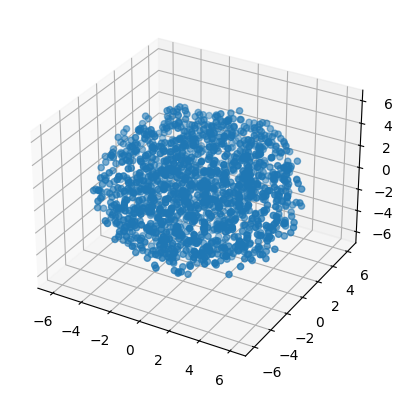

In [2]:
lambda1, lambda2 = 1, 1
M=1500
rho = 1
sigma = 0
lamda =0.0001*M**(-0.4)
np.random.seed(0)
torch.manual_seed(0)

data = sampling_ball(M)
xyz_data = torch.vmap(ball_transform)(data)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = xyz_data[:,0]
sequence_containing_y_vals = xyz_data[:,1]
sequence_containing_z_vals = xyz_data[:,2]

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
plt.show()

In [3]:
data = torch.tensor(sample_SE3(M), dtype = torch.float32)
vec_field = generate_data(data).flatten()
c_hat = coefficients_c(data, vec_field, lamda, rho)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_11415/1055500085.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(sample_SE3(M), dtype = torch.float32)


In [4]:
prediction(sample_SE3(1), rho)

tensor(-10.6192)

In [5]:
A = sample_SE3(1)
A

tensor([[ 0.9962, -0.0868, -0.0072,  0.0854,  0.9571,  0.2768, -0.0171, -0.2764,
          0.9609,  0.0044,  0.9634, -0.0058]])

In [6]:
generate_data(A)

tensor([[ 3.6305, -0.0433, -1.0073, -0.4049, -6.5415, -1.1375]])

In [7]:
Vec_Field(torch.tensor(A[0], dtype=torch.float32, requires_grad = True), 0)

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_11415/1172563745.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Vec_Field(torch.tensor(A[0], dtype=torch.float32, requires_grad = True), 0)


tensor([ 3.6305, -0.0433, -1.0073, -0.4049, -6.5415, -1.1375],
       grad_fn=<AddBackward0>)

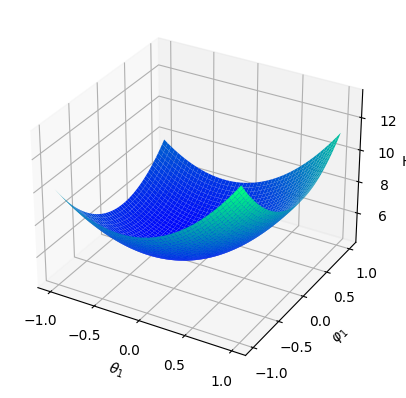

In [27]:
#Plot Ground Truth Hamiltonian
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        SO3 = exp_so3(torch.Tensor([1,1,1])).flatten()
        Z1[i,j] = potential(torch.cat((SO3,torch.Tensor([X[i][j],Y[i][j],0]))))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
# plt.savefig("Groundtruth_Sphere_Norm.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

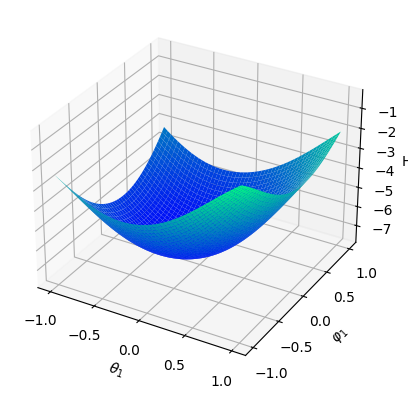

In [28]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        SO3 = exp_so3(torch.Tensor([1,1,1])).flatten()
        Z2[i,j] = prediction(torch.cat((SO3,torch.Tensor([X[i][j],Y[i][j],0]))), rho).detach()
Z2 = Z2.numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
# plt.savefig("Learned_Sphere_Norm.png", bbox_inches='tight')
plt.show()

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_11106/2509718101.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(torch.cat((SO3,torch.Tensor([X[i][j],Y[i][j],0]))), dtype=torch.float32, requires_grad = True)


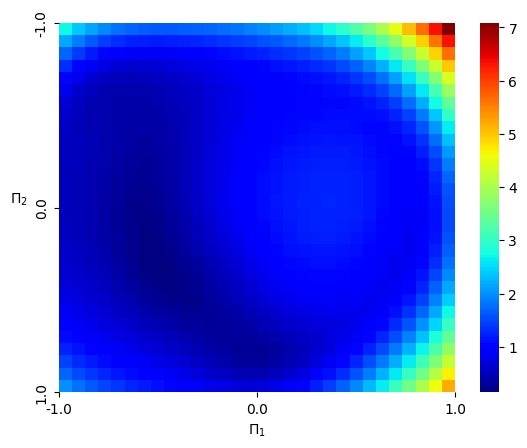

In [29]:
#Plot Hamiltonian Vector Field Error
grid = 30
x = np.linspace(-1, 1, grid)
y = np.linspace(-1, 1, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        SO3 = exp_so3(torch.Tensor([1,1,1])).flatten()
        input_ = torch.tensor(torch.cat((SO3,torch.Tensor([X[i][j],Y[i][j],0]))), dtype=torch.float32, requires_grad = True)
        U = Vec_Field(input_, 0).detach()
        V = Prediction_Vec_Field(data, input_, c_hat, rho).detach()
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.numpy()

ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,3))
ax.set_xticklabels(f'{c:.1f}' for c in range(-1,2))
ax.set_yticks(np.linspace(0,grid,3))
ax.set_yticklabels(f'{c:.1f}' for c in range(-1,2))
plt.xticks(rotation=0)
plt.xlabel(r'$\Pi_1$')
plt.ylabel(r'$\Pi_2$', rotation=0)
plt.show()

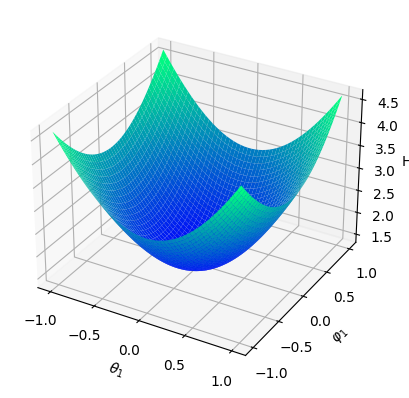

In [30]:
#Plot Ground Truth Hamiltonian
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)

X, Y = np.meshgrid(x, y)
Z1 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        SO3 = exp_so3(torch.Tensor([X[i][j],Y[i][j],1])).flatten()
        Z1[i,j] = potential(torch.cat((SO3,torch.Tensor([0,0,0]))))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z1, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
# plt.savefig("Groundtruth_Sphere_Norm.png", bbox_inches='tight')
plt.show()

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(train_data[:,0].detach().numpy(), train_data[:,1].detach().numpy(), color = "black")
# plt.show()

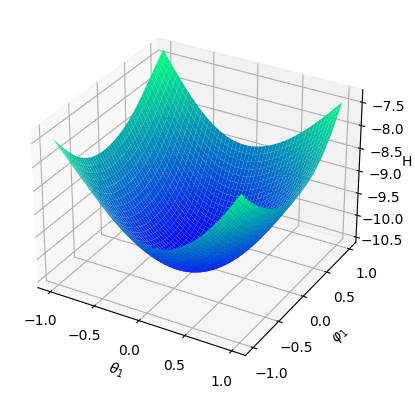

In [31]:
#Uniform on the sphere
#Plot Predicted Hamiltonian
x = np.linspace(-1, 1, 50)
y = np.linspace(-1, 1, 50)

X, Y = np.meshgrid(x, y)
Z2 = torch.zeros((50,50))
for i in range(50):
    for j in range(50):
        SO3 = exp_so3(torch.Tensor([X[i][j],Y[i][j],1])).flatten()
        Z2[i,j] = prediction(torch.cat((SO3,torch.Tensor([0,0,0]))), rho).detach()
Z2 = Z2.numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z2, cmap=plt.get_cmap('winter'))
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\varphi_1$')
ax.set_zlabel('H', rotation=0)
ax.zaxis.labelpad=0
# plt.savefig("Learned_Sphere_Norm.png", bbox_inches='tight')
plt.show()

/var/folders/mh/ml0ws0cd405fvf5vf8vkrfn80000gn/T/ipykernel_11106/3834724648.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ = torch.tensor(torch.cat((SO3,torch.Tensor([0,0,0]))), dtype=torch.float32, requires_grad = True)


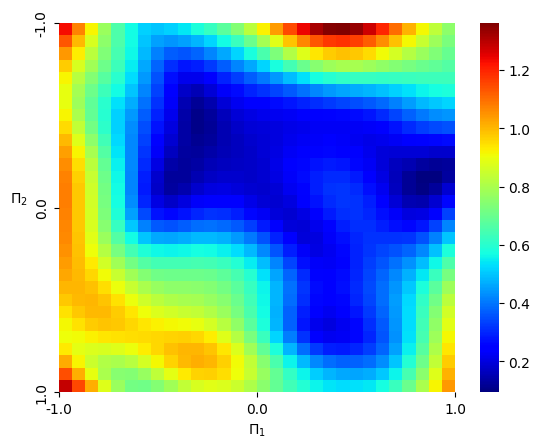

In [32]:
#Plot Hamiltonian Vector Field Error
grid = 30
x = np.linspace(-1, 1, grid)
y = np.linspace(-1, 1, grid)

X, Y = np.meshgrid(x, y)
Z = torch.zeros((grid,grid))
for i in range(grid):
    for j in range(grid):
        SO3 = exp_so3(torch.Tensor([X[i][j],Y[i][j],1])).flatten()
        input_ = torch.tensor(torch.cat((SO3,torch.Tensor([0,0,0]))), dtype=torch.float32, requires_grad = True)
        U = Vec_Field(input_, 0).detach()
        V = Prediction_Vec_Field(data, input_, c_hat, rho).detach()
        Z[i,j] = torch.norm(U-V, p=2)
        
Ham_vec_error = Z.numpy()

ax = sns.heatmap(Ham_vec_error, cmap='jet')
ax.yaxis.set_label_coords(-0.1,1.02)
ax.set_xticks(np.linspace(0,grid,3))
ax.set_xticklabels(f'{c:.1f}' for c in range(-1,2))
ax.set_yticks(np.linspace(0,grid,3))
ax.set_yticklabels(f'{c:.1f}' for c in range(-1,2))
plt.xticks(rotation=0)
plt.xlabel(r'$\Pi_1$')
plt.ylabel(r'$\Pi_2$', rotation=0)
plt.show()